Install Necessary Packages

In [1]:
%pip install matplotlib
%pip install pandas
%pip install scikit-learn
%pip install setuptools
%pip install distlib
%pip install tensorflow
%pip install openpyxl
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import all necessary packages

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

Load user activity log data

In [3]:
# create pandas dataframe for user log csv file
log_df = pd.read_excel('user_log_data.xlsx')
log_df.columns

Index(['Time Stamp', 'Source User', 'Target User ', 'Source System',
       'Data Classification ', 'Authentication Type', 'Server Type',
       'Login Result ', 'Anomalous', 'Comments'],
      dtype='object')

In [4]:
# print top 5 records
log_df.head()

,Time Stamp,Source User,Target User,Source System,Data Classification,Authentication Type,Server Type,Login Result,Anomalous,Comments
0,11:20:00,C625$@DOM1,SYSTEM@C653,PC-1234,High,SSO,External,Success,Yes,SSO on external Server is not a good approach
1,19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,Medium,2 Factor Auth,Internal,Success,No,NaN
2,19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,Low,2 Factor Auth,Internal,Success,No,NaN
3,19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,High,2 Factor Auth,Internal,Success,No,NaN
4,17:20:00,C625$@DOM3,SYSTEM@C655,PC-1236,Low,Adaptive Auth,External,Success,No,NaN


In [5]:
# print number of rows and columns in dataset
log_df.shape

(3500, 10)

Format column names

In [6]:
# Remove space in column name and join them with underscore
log_df = log_df.rename(columns={col: col.strip().replace(' ', '_') for col in log_df.columns})
log_df.head()

,Time_Stamp,Source_User,Target_User,Source_System,Data_Classification,Authentication_Type,Server_Type,Login_Result,Anomalous,Comments
0,11:20:00,C625$@DOM1,SYSTEM@C653,PC-1234,High,SSO,External,Success,Yes,SSO on external Server is not a good approach
1,19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,Medium,2 Factor Auth,Internal,Success,No,NaN
2,19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,Low,2 Factor Auth,Internal,Success,No,NaN
3,19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,High,2 Factor Auth,Internal,Success,No,NaN
4,17:20:00,C625$@DOM3,SYSTEM@C655,PC-1236,Low,Adaptive Auth,External,Success,No,NaN


Create Access time column from timestamp

In [7]:
# create access time column based on timestamp

log_df['Time_Stamp'] = pd.to_datetime(log_df['Time_Stamp'], format='%H:%M:%S')

def classify_time(hour):
    if 0 <= hour < 6:
        return 'Midnight'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

hour = log_df['Time_Stamp'].dt.hour
log_df['Access_Time'] = hour.apply(classify_time)

log_df.head()

,Time_Stamp,Source_User,Target_User,Source_System,Data_Classification,Authentication_Type,Server_Type,Login_Result,Anomalous,Comments,Access_Time
0,1900-01-01 11:20:00,C625$@DOM1,SYSTEM@C653,PC-1234,High,SSO,External,Success,Yes,SSO on external Server is not a good approach,Morning
1,1900-01-01 19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,Medium,2 Factor Auth,Internal,Success,No,NaN,Evening
2,1900-01-01 19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,Low,2 Factor Auth,Internal,Success,No,NaN,Evening
3,1900-01-01 19:20:00,C625$@DOM2,SYSTEM@C654,PC-1235,High,2 Factor Auth,Internal,Success,No,NaN,Evening
4,1900-01-01 17:20:00,C625$@DOM3,SYSTEM@C655,PC-1236,Low,Adaptive Auth,External,Success,No,NaN,Afternoon


Create synthetic data (Update Anomalous column based on rules)

In [8]:
# set rules for synthetic data
valid_source_user = ['C625$@DOM1', 'C625$@DOM2', 'C625$@DOM3', 'C625$@DOM4','C625$@DOM5','C625$@DOM6','C625$@DOM8']
valid_target_user = ['SYSTEM@C653', 'SYSTEM@C654','SYSTEM@C655','SYSTEM@C656','SYSTEM@C657','SYSTEM@C658','SYSTEM@C660']
valid_source_system = ['PC-1234', 'PC-1235', 'PC-1236', 'PC-1237', 'PC-1238', 'PC-1239', 'PC-1241']

def update_anomalous(row):
    anomalous = 'No'
    comment = None
    if row['Source_User'] not in valid_source_user:
        anomalous = 'Yes'
        comment = 'Invalid source user'
    elif row['Target_User'] not in valid_target_user:
        anomalous = 'Yes'
        comment = 'Invalid target user'
    elif row['Source_System'] not in valid_source_system:
        anomalous = 'Yes'
        comment = 'Invalid source system'
    elif row['Access_Time'] == 'Midnight':
        anomalous = 'Yes'
        comment = 'Time is odd'
    elif row['Data_Classification'] == 'High' and row['Authentication_Type'] == 'SSO' and row['Server_Type'] == 'External':
        anomalous = 'Yes'
        comment = 'SSO on external Server is not a good approach'
    elif row['Data_Classification'] == 'High' and row['Authentication_Type'] == 'HTTP Basic Auth' and row['Server_Type'] in ['Internal', 'External']:
        anomalous = 'Yes'
        comment = 'Basic Auth is not good for critical data'
    elif row['Data_Classification'] in ['High','Low', 'Medium'] and row['Authentication_Type'] == 'OAuth' and row['Server_Type'] == 'External':
        anomalous = 'Yes'
        comment = 'Supplement additional authentication such as certificate or allowlist'
    row['Anomalous'] = anomalous
    row['Comments'] = comment
    return row

# Apply the function to each row
log_df = log_df.apply(update_anomalous, axis=1)
log_df.tail()


,Time_Stamp,Source_User,Target_User,Source_System,Data_Classification,Authentication_Type,Server_Type,Login_Result,Anomalous,Comments,Access_Time
3495,2020-06-11 19:36:19,C625$@DOM2,SYSTEM@C658,PC-1235,High,2 Factor Auth,External,Success,No,None,Evening
3496,2020-04-21 20:24:41,C625$@DOM5,SYSTEM@C656,PC-1235,Medium,2 Factor Auth,Internal,Success,No,None,Evening
3497,2020-05-03 02:39:33,C625$@DOM2,SYSTEM@C656,PC-1234,Low,2 Factor Auth,External,Success,Yes,Time is odd,Midnight
3498,2020-04-10 00:37:30,C625$@DOM1,SYSTEM@C655,PC-1237,Low,2 Factor Auth,Internal,Success,Yes,Time is odd,Midnight
3499,2020-02-21 11:28:46,C625$@DOM1,SYSTEMMMM@C654,PC-1234,Low,2 Factor Auth,External,Success,Yes,Invalid target user,Morning


Remove space from all cell values

In [9]:
# strip space from all string values
log_df = log_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

C:\Users\Chitt\AppData\Local\Temp\ipykernel_25784\1417334954.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_df = log_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Print count and percentage of Anomalous split up

In [10]:
# print anomalous split up percentage
anomalous_count = log_df['Anomalous'].value_counts().sort_index().reset_index()
anomalous_count.columns = ['Anomalous', 'Count']
anomalous_count['Percentage'] = round((anomalous_count['Count'] / len(anomalous_count)) * 100,2)
anomalous_count.sort_values(by='Anomalous')

,Anomalous,Count,Percentage
0,No,1683,84150.0
1,Yes,1817,90850.0


Filter only 2000 records

In [11]:
# Filter 2000 records with 80% No and 20% Yes
yes_records = log_df[log_df['Anomalous'] == 'Yes']
no_records = log_df[log_df['Anomalous'] == 'No']

yes_sample = yes_records.sample(n=400, random_state=42)
no_sample = no_records.sample(n=1600, random_state=42)

log_df = pd.concat([yes_sample, no_sample])
log_df.to_csv('user_log_final_data.csv', index=False)

Pie chart for anomalous distribution

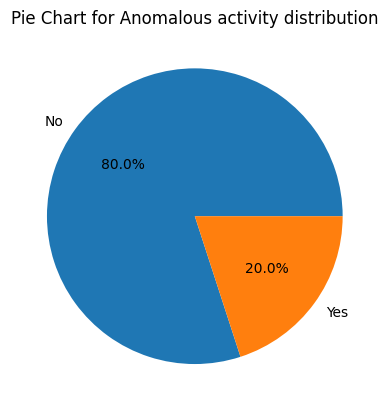

In [12]:
# Plot pie chart for anomalous activity distribution
log_df['Anomalous'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Pie Chart for Anomalous activity distribution')
plt.ylabel('')
plt.show()

Grouped bar chart for Anomalous vs Server type

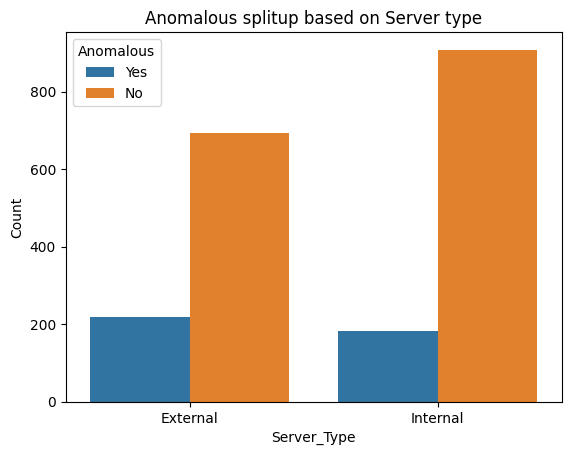

In [13]:
# Create the grouped bar plot for anomalous activity based on server type
sns.countplot(x='Server_Type', hue='Anomalous', data=log_df)
plt.title('Anomalous splitup based on Server type')
plt.xlabel('Server_Type')
plt.ylabel('Count')
plt.show()

In [14]:
# print column names
log_df.columns

Index(['Time_Stamp', 'Source_User', 'Target_User', 'Source_System',
       'Data_Classification', 'Authentication_Type', 'Server_Type',
       'Login_Result', 'Anomalous', 'Comments', 'Access_Time'],
      dtype='object')

Encode categorical columns

In [15]:
# encode categorical columns as binary values (0/1)
log_df = pd.get_dummies(log_df, columns=['Source_User','Target_User', 'Source_System', 'Data_Classification', 'Authentication_Type', 'Server_Type', 'Access_Time'], prefix_sep='_', dtype=int)
log_df['Anomalous'] = log_df['Anomalous'].replace({'Yes': 1, 'No': 0})
log_df.to_csv('user_log_encoded_data.csv', index=False)
log_df.columns

C:\Users\Chitt\AppData\Local\Temp\ipykernel_25784\865374209.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log_df['Anomalous'] = log_df['Anomalous'].replace({'Yes': 1, 'No': 0})


Index(['Time_Stamp', 'Login_Result', 'Anomalous', 'Comments',
       'Source_User_C625$@DOM1', 'Source_User_C625$@DOM2',
       'Source_User_C625$@DOM3', 'Source_User_C625$@DOM4',
       'Source_User_C625$@DOM5', 'Source_User_C625$@DOM6',
       'Source_User_C625$@DOM8', 'Source_User_C625$@DOMMMM2',
       'Target_User_SYSTEM@C653', 'Target_User_SYSTEM@C654',
       'Target_User_SYSTEM@C655', 'Target_User_SYSTEM@C656',
       'Target_User_SYSTEM@C657', 'Target_User_SYSTEM@C658',
       'Target_User_SYSTEM@C660', 'Target_User_SYSTEMMMM@C654',
       'Source_System_PC-1234', 'Source_System_PC-1235',
       'Source_System_PC-1236', 'Source_System_PC-1237',
       'Source_System_PC-1238', 'Source_System_PC-1239',
       'Source_System_PC-1241', 'Data_Classification_High',
       'Data_Classification_Low', 'Data_Classification_Medium',
       'Authentication_Type_2 Factor Auth', 'Authentication_Type_API Keys',
       'Authentication_Type_Adaptive Auth',
       'Authentication_Type_HTTP Basi

Split training and testing data

In [16]:
# split 80% training and 20% testing data
X = log_df.drop(columns=['Time_Stamp', 'Login_Result', 'Anomalous', 'Comments'])
y = log_df['Anomalous']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Create neural network model

In [17]:
# create neural network model
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

c:\Users\Chitt\Downloads\Deep Learning\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile model

In [18]:
# compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

Define Earlystopping to stop if there is no further improvement in model performance

In [19]:
# early stopping for stopping when there is no further improvement
early_stopping = EarlyStopping(
    monitor='val_loss',  # based on validation loss
    patience=5,          # wait till 5 epochs before stopping
    restore_best_weights=True  
)

Train model

In [20]:
# Train the model
model_history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping]) 

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8006 - loss: 0.5420 - val_accuracy: 0.8281 - val_loss: 0.4248
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8016 - loss: 0.4390 - val_accuracy: 0.8281 - val_loss: 0.3763
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8121 - loss: 0.3747 - val_accuracy: 0.8281 - val_loss: 0.3311
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7998 - loss: 0.3558 - val_accuracy: 0.8531 - val_loss: 0.2786
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8488 - loss: 0.2840 - val_accuracy: 0.9156 - val_loss: 0.2226
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9066 - loss: 0.2409 - val_accuracy: 0.9500 - val_loss: 0.1652
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9352 - loss: 0.1790 - val_accuracy: 0.9656 - val_loss: 0.1165
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9528 - loss: 0.1344 - val_accuracy: 0.9781 - val_loss:

Evaluate model based on testing data

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 1.0000 - loss: 0.0065    
Test Accuracy: 1.0


Plot learning curve

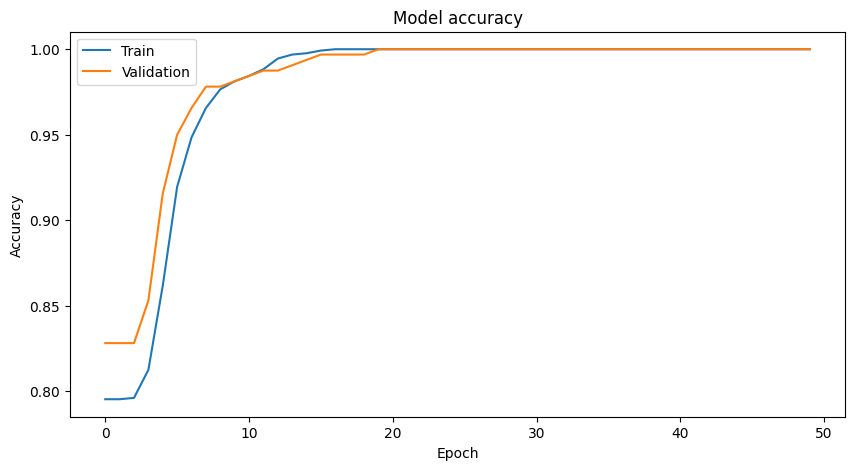

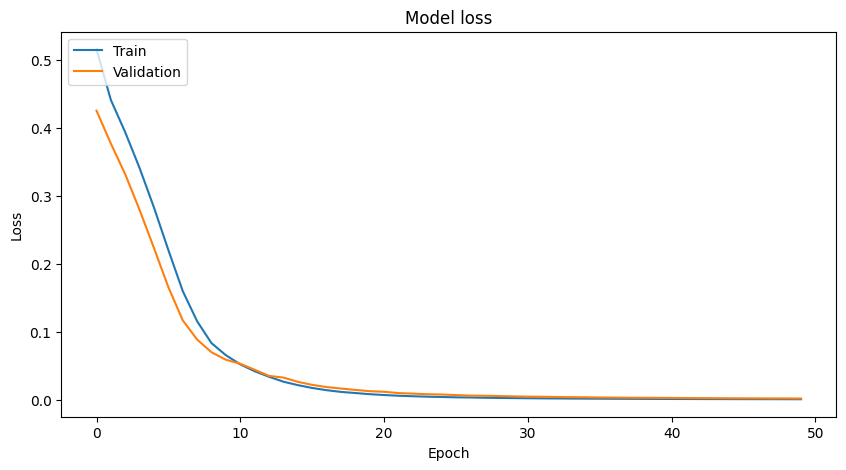

In [22]:
# Plot the values of training and validation accuracy for NN model
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the values of training & validation loss for NN model
plt.figure(figsize=(10, 5))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Classification report for testing data

In [23]:
# print evaluation metrics for testing data
# Predict anomalies
y_pred = model.predict(X_test)
y_pred_labels = (y_pred > 0.5).astype(int)

# Additional metrics (e.g., precision, recall, F1 score)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       317
           1       1.00      1.00      1.00        83

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



Display confusion matrix

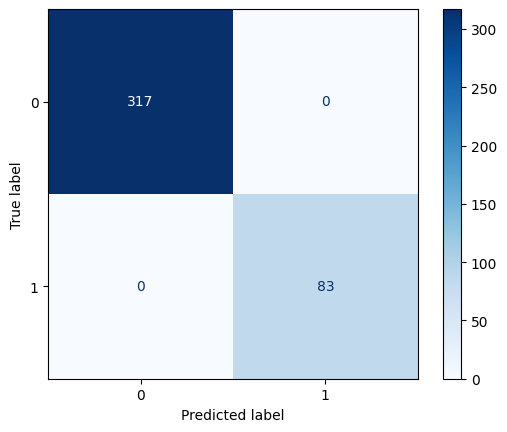

In [24]:
# plot confusion matrix for test data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Logistic regression model to predict probability for individual cases

In [40]:
# calculate probability scores for each class using logistic regression model
print('Logistic regression')
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy}")

# probabilities = model.predict_proba(X)

# # top 35 records contains all possible cases for the model
# # predict probability for them
# prob_df = pd.DataFrame(probabilities, columns=['Anomalous_No', 'Anomalous_Yes'])
# result_df = pd.concat([log_df.reset_index(drop=True), prob_df], axis=1)
# result_df.to_csv('probability_all_records.csv')
# result_df

probabilities = model.predict_proba(X_test)

prob_df = pd.DataFrame(probabilities, columns=['Anomalous_No', 'Anomalous_Yes'])
print('Predicted average anomalous activity on test data:', prob_df['Anomalous_Yes'].mean())
print('Predicted average non-anomalous activity on test data:', prob_df['Anomalous_No'].mean())

Logistic regression
Model Accuracy: 0.96
Predicted average anomalous activity on test data: 0.19840078349681944
Predicted average non-anomalous activity on test data: 0.8015992165031806
